## Q-learning with shallow function approximator

**Algorithm: Q-learning with shallow function approximator**

---

Initialize replay memory D to capacity N

Initialize action-value function Q with random weights

**for** episode = 1 to M **do**

&nbsp;&nbsp;&nbsp;&nbsp; Initialize sequence $s_{1} = \{x_{1}\}$ and preprocessed sequence $\phi_{1} = \phi(s_{1})$

&nbsp;&nbsp;&nbsp;&nbsp; **for** t = 1 to T **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $a_{t} = \begin{cases} \max_{a}Q(\phi(s_{t}), a; \theta)&\text{with probability } 1-\epsilon \\ \text{random action }&\text{with probability } \epsilon \end{cases}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Execute action $a_{t}$ and observe reward $r_{t}$ and image $x_{t+1}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $s_{t+1}=s_{t}$, and preprocess $\phi_{t+1} = \phi(s_{t+1})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Store transition ($\phi_{t}, a_{t}, r_{t}, \phi_{t+1}$) in D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample random minibatch of transitions ($\phi_{j}, a_{j}, r_{j}, \phi_{j+1}$) from D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y_{j} = \begin{cases} r_{j}&\text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'} Q(\phi_{j+1}, a'; \theta)&\text{for non-terminal } \phi_{j+1} \end{cases}$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Fit the approximator with (states,  $y_{j}$)

&nbsp;&nbsp;&nbsp;&nbsp; **end for**

**end for**

---

s = state, 

a = current action, 

a' = action for the next state, 

$\theta$ = parameters for the function approximator, 

$Q(s,a;\theta)$: action-value function estimated by a function approximator



In [5]:
import gym
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os.path
import copy
from PIL import Image
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import numpy as np
import time
import datetime

In [38]:
class GB_DQN(): 
    
    def __init__(self, n_state, n_action):
        self.n_action = n_action
        self.model = MultiOutputRegressor(LGBMRegressor(n_estimators=100, learning_rate= 0.1, boosting_type="goss", n_jobs=4, importance_type="gain", reg_alpha=0, subsample=1))
        self.isFit = False

    def predict(self, s):            
        # s: (4,) array (for cartpole)
        s = np.array(s).reshape(1,-1) # converts (4,) to (1,4) (2 dimensional)
        result = self.model.predict(s)
        # result: (1,2) array (for cartpole)
        return result

    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        def policy_function(state):
            # state: (4,) array
            if random.random() < epsilon:
                return random.randint(0, n_action - 1) # int
            else:
                if self.isFit == True:
                    q_values = self.predict(state) # (1,2) array
                else: 
                    return random.randint(0, n_action - 1) # int
            return np.argmax(q_values) # int
        return policy_function

    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size) # draw random batch
            states = [] # list
            targets = [] # list
            
            for state, action, next_state, reward, is_done in replay_data:
            # state: (4,) array (for cartpole)
            # action: integer
            # next_state: (4,) array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)    
                states.append(state) # (r, 4) array (for cartpole) where r= # replay_data
                
                if self.isFit == False: # At the very beginning, initialize q_values
                    q_values = [0] * self.n_action # (2,) array

                else:
                    q_values = self.predict(state).tolist()[0]
                    # approx q-value from the model
                    # state: (,4) array 
                    # q_values: (2,) array                    

                    if is_done == False: # if not terminal
                        q_values_next = self.predict(next_state) # (1,2) array
                        q_update = reward + gamma * np.argmax(q_values_next) # int
                    else: # if terminal
                        q_update = -1 * reward
                    
                    q_values[action] = q_update # q_values: (2,) 1d array

                targets.append(q_values) # (r, 2) array (for cartpole)
                # td_targets must take q_values as (2,) 1d array 
            
            self.model.fit(states, targets)
            self.isFit = True


In [39]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.95):
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state) # integer
            
            next_state, reward, is_done, _ = env.step(action)
            # next_state: 4x1 array (for cartpole)
            # reward: integer
            # is_done: bool (True/False)
            
            total_reward_episode[episode] += reward
            memory.append((state, action, next_state, reward, is_done))
            
            if is_done:
                break
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        epsilon = np.max([epsilon * epsilon_decay, 0.01])

100%|██████████| 300/300 [04:45<00:00,  1.05it/s]
learning duration = 285
mean reward =  18.34
max reward =  73.0


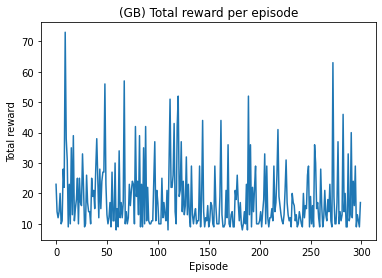

<Figure size 432x288 with 0 Axes>

In [42]:
backup_file_name = "GB_CartPole_" + time.strftime("%y%m%d") + "_1"
backup_file = backup_file_name + ".p"
backup_check = os.path.isfile(backup_file)

if backup_check == True:
    with open(backup_file, "rb") as file:
        myEnv = pickle.load(file)
    total_reward_episode = myEnv["t_r_e"]
    duration = myEnv["duration"]

else:    
    env = gym.envs.make("CartPole-v1")
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n

    dqn = GB_DQN(n_state, n_action)
    memory = deque(maxlen=10000)
    n_episode = 600
    replay_size = 32

    total_reward_episode = [0] * n_episode

    start = time.time()
    
    q_learning(env, dqn, n_episode, replay_size, gamma=0.99, epsilon=1.0) # runs the alg
    
    end = time.time()
    duration = int(end - start)
    
    myEnv = dict()
    myEnv["t_r_e"] = total_reward_episode
    myEnv["duration"] = duration

    with open(backup_file, "wb") as file:
        pickle.dump(myEnv, file)

img_file = backup_file_name + ".png"
print("learning duration =", duration)
print("mean reward = ", np.mean(total_reward_episode))
print("max reward = ", max(total_reward_episode))
plt.plot(total_reward_episode)
plt.title("(GB) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()
plt.savefig(img_file)

In [37]:
print("learning duration =", duration)

learning duration = 289
